In [159]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [160]:
# Load the dataset
dframe = pd.read_csv("/home/jovyan/work/data/health/filtered_full_relabel_i2b2.csv", encoding="ISO-8859-1")

def get_sentences(dataset):
    n_sent = 1
    grouped = dataset.groupby("sentence_idx").apply(lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                                                      s["tag"].values.tolist())])
    sentences = [s for s in grouped]

    def get_next():
        nonlocal n_sent
        try:
            s = grouped["Sentence: {}".format(n_sent)]
            n_sent += 1
            return s
        except:
            return None

    return sentences, get_next

# Split the data into test and train sets
train_df, test_df = train_test_split(dframe, test_size=0.4)

train_df = train_df.sort_values(by='sentence_idx')
test_df = test_df.sort_values(by='sentence_idx')

train_df.to_csv("/home/jovyan/work/data/health/lstm/train.csv", index=False)
test_df.to_csv("/home/jovyan/work/data/health/lstm/test.csv", index=False)

# Get the sentences from the train set
train_sentences, _ = get_sentences(train_df)


# Get the maximum sequence length from the train sentences
maxlen = max([len(s) for s in train_sentences])
print('Maximum sequence length:', maxlen)

# Get the unique words and tags from the train set
words = list(set(train_df["word"].values))
words.append("ENDPAD")
tags = list(set(train_df["tag"].values))

words_full = list(set(dframe["word"].values))
words.append("ENDPAD")
tags_full = list(set(dframe["tag"].values))

# Create word and tag dictionaries
word2idx = {w: i for i, w in enumerate(words_full)}
word2idx["<OOV>"] = len(words_full)  # Add "<OOV>" with a new index value
tag2idx = {t: i for i, t in enumerate(tags_full)}



# Preprocess the train set
X_train = [[word2idx.get(w[0], word2idx["<OOV>"]) for w in s] for s in train_sentences]
X_train = pad_sequences(maxlen=maxlen, sequences=X_train, padding="post", value=len(words) - 1)
y_train = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y_train = pad_sequences(maxlen=maxlen, sequences=y_train, padding="post", value=tag2idx["O"])
y_train = [to_categorical(i, num_classes=len(tags)) for i in y_train]

# Get the sentences from the test set
test_sentences, _ = get_sentences(test_df)

# Preprocess the test set
X_test = [[word2idx.get(w[0], word2idx["<OOV>"]) for w in s] for s in test_sentences]
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post", value=len(words) - 1)
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(i, num_classes=len(tags)) for i in y_test]

n_words = len(words_full);
n_tags = len(tags_full);


Maximum sequence length: 68


In [18]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
input_t = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=100, input_length=maxlen)(input_t)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
model = Model(input_t, out)
from keras.losses import CategoricalCrossentropy

cross_entropy_loss = CategoricalCrossentropy()
model = Model(input_t, out)
model.compile(optimizer="adam", loss=cross_entropy_loss, metrics=["categorical_accuracy"])
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, verbose=1)

Epoch 1/5
358/358 [==============================] - 45s 114ms/step - loss: 0.2232 - categorical_accuracy: 0.9656
Epoch 2/5
358/358 [==============================] - 42s 118ms/step - loss: 0.0890 - categorical_accuracy: 0.9748
Epoch 3/5
358/358 [==============================] - 47s 132ms/step - loss: 0.0680 - categorical_accuracy: 0.9808
Epoch 4/5
358/358 [==============================] - 58s 162ms/step - loss: 0.0532 - categorical_accuracy: 0.9855
Epoch 5/5
358/358 [==============================] - 55s 154ms/step - loss: 0.0411 - categorical_accuracy: 0.9883


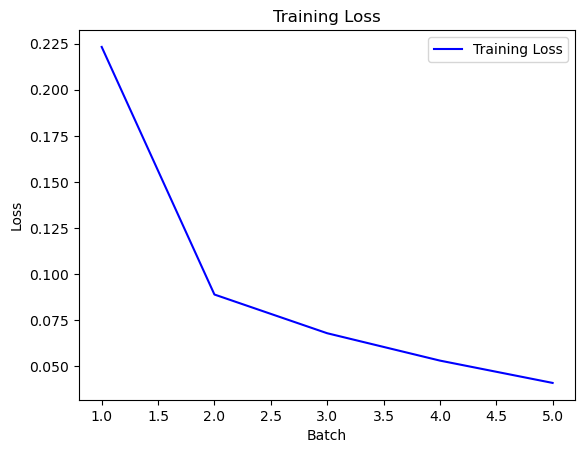

In [19]:
# Access the loss values and batch numbers from the history
loss_values = history.history['loss']
batches = range(1, len(loss_values) + 1)

# Plot the loss value over batches with a line
plt.plot(batches, loss_values, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
import tensorflow as tf
lstm_dir = "/home/jovyan/work/data/output/LSTM_health_b10_s4_b32"
model = tf.keras.models.load_model(lstm_dir)

In [4]:
y_pred = model.predict(X_test)
X_test.shape
y_pred_indices = np.argmax(y_pred, axis=-1)

y_pred_flattened = y_pred_indices.flatten()
y_true_indices = np.argmax(y_test, axis=-1)
y_true_flattened = y_true_indices.flatten()
precision_per_tag = {}
recall_per_tag = {}
f1_per_tag = {}
for tag, id in tag2idx.items():
    true_positives = np.sum((y_pred_flattened == id) & (y_true_flattened == id))
    false_positives = np.sum((y_pred_flattened == id) & (y_true_flattened != id))
    false_negatives = np.sum((y_pred_flattened != id) & (y_true_flattened == id))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision_per_tag[tag] = round(precision, 2) * 100
    recall_per_tag[tag] = round(recall, 2) * 100
    f1_per_tag[tag] = round(f1_score, 2) * 100

from tabulate import tabulate

sorted_tags = sorted(tag2idx.items(), key=lambda x: x[0])

table_data = []
for tag, id in sorted_tags:
    row = [tag, precision_per_tag[tag], f1_per_tag[tag], recall_per_tag[tag]]
    table_data.append(row)

table_headers = ["Tag", "Precision", "F1 Score", "Recall"]
table = tabulate(table_data, headers=table_headers, tablefmt="plain", colalign=("left", "left", "left", "left"))

print(table)


355/355 [==============================] - 8s 21ms/step
Tag              Precision    F1 Score    Recall
B-AGE            0            0           0
B-HOSPITAL       3            1           1
B-MEDICALRECORD  2            0           0
B-ORGANIZATION   0            0           0
B-PER            4            1           0
B-PROFESSION     0            0           0
B-STATE          0            0           0
B-STREET         0            0           0
CITY             0            1           18
COUNTRY          0            0           3
DATE             0            0           0
EMAIL            0            0           0
FAX              0            0           0
I-AGE            0            0           0
I-HOSPITAL       0            0           0
I-MEDICALRECORD  0            0           0
I-ORGANIZATION   0            0           0
I-PER            0            0           0
I-PROFESSION     0            0           0
I-STATE          0            0           0
I-STREET      

In [28]:
# Evaluation
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

354/354 [==============================] - 37s 102ms/step - loss: 0.0427 - categorical_accuracy: 0.9886
Loss: 0.0427
Accuracy: 98.86%


In [24]:
dir = "/home/jovyan/work/data/output/LSTM_health_b10_s4_b32"
model.save(dir)

2023-06-18 23:02:15.717386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-06-18 23:02:15.828899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-06-18 23:02:15.886513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and 

INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTM_health_b10_s4_b32/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTM_health_b10_s4_b32/assets


In [21]:
num_tags = train_df['tag'].value_counts()
print("Number of unique tags:", num_tags)


Number of unique tags: tag
O                  161706
DATE                11294
B-PER                4011
I-PER                3410
B-HOSPITAL           1283
I-HOSPITAL           1127
B-AGE                1123
I-MEDICALRECORD       882
PHONE                 753
B-MEDICALRECORD       583
IDNUM                 549
CITY                  468
I-STREET              407
B-STATE               256
B-PROFESSION          241
ZIP                   217
B-STREET              213
I-PROFESSION          207
USERNAME              140
B-ORGANIZATION        123
I-ORGANIZATION        114
COUNTRY                63
I-AGE                  28
FAX                    24
I-STATE                 8
EMAIL                   3
Name: count, dtype: int64


### Output File

In [20]:
y_pred = model.predict(X_test)

354/354 [==============================] - 8s 20ms/step


In [21]:

y_pred_indices = np.argmax(y_pred, axis=-1)
y_pred_flattened = y_pred_indices.flatten()
y_true_indices = np.argmax(y_test, axis=-1)
y_true_flattened = y_true_indices.flatten()
print(y_true_flattened)

[18  1  1 ...  1  1  1]


In [135]:
X_test_words = []
for seq in X_test:
    for idx in seq:
        word = list(word2idx.keys())[idx]
        X_test_words.append(word)



In [150]:
sentence_Number = []
counter = 0
for seq in X_test:
    counter += 1
    for idx in seq:
        sentence_Number.append(counter)



In [31]:
y_lstm_prediction = [list(tag2idx.keys())[idx] for idx in y_pred_flattened]

In [32]:
y_lstm_true = [list(tag2idx.keys())[idx] for idx in y_true_flattened]

In [152]:
data = {'sentence_idx': sentence_Number,'word': X_test_words, 'y_true_lstm': y_lstm_true, 'y_pred_lstm': y_lstm_prediction}
df = pd.DataFrame(data)

In [158]:
dir_output = "/home/jovyan/work/data/hybrid/lstm_output.csv"
df.to_csv(dir_output)

In [157]:
count_equal = (df['y_true_lstm'] == df['y_pred_lstm']).sum()

# Print the count
print(count_equal)

817170


In [ ]:
# print(X_test.shape,len(X_true_indices),len(X_true_flattened))
# print(len(y_test),len(y_true_indices),len(y_true_flattened))
# print(len(y_pred),len(y_pred_indices),len(y_true_flattened))
#
# (11323, 73) 11323 11323
# 11323 11323 826579
# 11323 11323 826579